# Project 4: Predicting Volatility Index price with Sentiment Analysis on News headlines

### Notebook 3 : Classifier Models - For Volatility Index Price Direction (Up or Down) 

This portion of the notebook will be modelling to predict if VIX (Y variable) is up or down on , we will be using the below models :

1. 3 layers of Stacked LSTM

In [1]:
# INSTALLING Tensorflow 

#Use Anaconda prompt and run the command 'pip install tensorflow==2.0.0'

In [2]:
# To isntall  keras run the below command

#!pip install keras

# Importing Libraries

In [3]:
# get some libraries that will be useful
import re
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt
import pandas_datareader as dr
#To remove weekends from dataset
from pandas.tseries.offsets import BDay

# function for encoding categories

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#keras modeling
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

Using TensorFlow backend.


In [4]:
# grab the data #we will first grab the news data set first
combined_news = pd.read_csv("../data/final_dataframe.csv")

In [5]:
combined_news.head()

,Date,all25,upordown
0,2008-08-08,"0,b""georgia 'downs two russian warplanes' as c...",0.0
1,2008-08-11,"1,b'why wont america and nato help us? if they...",0.0
2,2008-08-12,"0,b'remember that adorable 9-year-old who sang...",1.0
3,2008-08-13,"0,b' u.s. refuses israel weapons to attack ira...",0.0
4,2008-08-14,"1,b'all the experts admit that we should legal...",0.0


## Preprocessor function to clean the text 

The final iteration of cleaner(text) does the following:

1. Grouping into stems
2. Excluding stopwords
3. Removing punctuation
4. Removing digits
5. Removing spaces

### This function will be used as preprocessor on both CountVectorizer and TfidfVectorizer

Some words share the same stem and can be combined in the next round of CountVectorize: file/files, game/games, http/https, imgur/imgur com, run/running, start/started, thing/things, tried/try/trying, use/used/using, windows/windows 10, work/working/works.

We will use porter stemmer to clean the words 

In [6]:
def cleaner(text):
    stemmer = PorterStemmer()                                          # groups words having the same stems
    stop = stopwords.words('english')                                  # excludes stop words
    text = text.translate(str.maketrans('', '', string.punctuation))   # removes punctuation
    text = text.translate(str.maketrans('', '', string.digits))        # removes digits
    text = text.lower().strip()                                        # removes spaces
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

In [7]:
basicvectorizer = CountVectorizer(preprocessor=cleaner,  
                                  min_df=0.03, 
                                  max_df=0.97, 
                                  max_features = 200000, 
                                  ngram_range = (2, 2))

# DEEP LEARNING

## LSTM + tokenizer

In [8]:
# We will redefine again before we head into the machine learning.

In [9]:
X = combined_news
y = combined_news['upordown']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10,stratify = y)

In [10]:
#to form a string for all top 25 of news headlines for X_train
trainheadlines = []
for row in range(0,len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,1:3]))

In [11]:
#Create test headlines again
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,1:3]))

### Next we will vectorize the text samples into a 2D integer tensor for processing

In [12]:
#num_words - This will be the maximum number of words 
#from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 10000 most common words in our case.
tokenizer = Tokenizer(num_words=10000)
# Tokenize our training data'trainheadlines'
tokenizer.fit_on_texts(trainheadlines)
# Encode training data sentences into sequences for both train and test data.
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [13]:
print('Pad sequences (samples x time)')

#Features for model training
#nb_classes - total number of classes.
nb_classes = 2
# maxlen is feature of maximum sequence length for padding our encoded sentences
maxlen = 200

# Pad the training sequences as we need our encoded sequences to be of the same length. 
# use that to pad all other sequences with extra '0's at the end ('post') and
# will also truncate any sequences longer than maximum length from the end ('post') as well. 
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_val = sequence.pad_sequences(sequences_test, maxlen=maxlen)

#convert them into array before we put them into model
y_train = np.array(y_train)
y_val = np.array(y_val)

# np_utils.to_categorical to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
Y_train = np_utils.to_categorical(y_train, 2)
Y_val = np_utils.to_categorical(y_val, 2)

#print out X_train and X_test shape.
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', Y_train.shape)
print('y_val shape:', Y_val.shape)

Pad sequences (samples x time)
X_train shape: (1790, 200)
X_val shape: (199, 200)
y_train shape: (1790, 2)
y_val shape: (199, 2)


# 3 layers of Stacked LSTM for sequence classification

Sequence classification is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence which may apply in this case.

In this model, we stack 3 LSTM layers on top of each other, making the model capable of learning higher-level temporal representations.

The first two LSTMs return their full output sequences, but the last one only returns the last step in its output sequence, thus dropping the temporal dimension (i.e. converting the input sequence into a single vector).

In [14]:
print('Build LSTM model...')
# expected input data shape: (batch_size, timesteps, data_dim)
data_dim = 16
timesteps = 8
max_features = 10000
#intialize model
model = Sequential()
#Embedding with 128
model.add(Embedding(max_features, 128))
# returns 16 sequences of vectors of dimension 32
model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, 16)))  
# returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True)) 
# return a single vector of dimension 32
model.add(LSTM(32))  
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
#Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build LSTM model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          20608     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 1,317,314
Trainable params: 1,317,314
Non-trainable params: 0
________________________

In [15]:
# Final evaluation of the model
history = model.fit(X_train, Y_train,
          batch_size=64, epochs=3,
          validation_data=(X_val, Y_val))

C:\Users\derri\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1790 samples, validate on 199 samples
Epoch 1/3
1790/1790 [==============================] - 11s 6ms/step - loss: 0.6695 - accuracy: 0.6017 - val_loss: 0.6564 - val_accuracy: 0.6030
Epoch 2/3
1790/1790 [==============================] - 10s 5ms/step - loss: 0.4919 - accuracy: 0.7168 - val_loss: 0.6176 - val_accuracy: 0.6633
Epoch 3/3
1790/1790 [==============================] - 10s 6ms/step - loss: 0.0842 - accuracy: 0.9838 - val_loss: 0.3919 - val_accuracy: 0.8492


In [16]:
print("Generating training accuracy...")
#We take an average of the training accuracy score
trainingacc5 = np.mean(history.history['accuracy'])
print('Training Accuracy Score: ',trainingacc5)
trainingvalacc5 = np.mean(history.history['val_accuracy'])
print('Training Validation Score: ',trainingvalacc5)

Generating training accuracy...
Training Accuracy Score:  0.76741153
Training Validation Score:  0.7051926255226135


In [17]:
print("Generating test predictions...")
score, acc = model.evaluate(X_val, Y_val,batch_size=64)
preds5 = model.predict_classes(X_val, verbose=0)
acc5 = accuracy_score(y_val, preds5)
print('Prediction accuracy: ', acc5)

Generating test predictions...
199/199 [==============================] - 0s 2ms/step
Prediction accuracy:  0.8492462311557789


In [18]:
# predict ROC-AUC score 
predictions = model.predict_proba(X_val)
rocauc5 = str(roc_auc_score(Y_val, predictions))
print("ROC-AUC-score5 :", rocauc5)

ROC-AUC-score5 : 0.9505274261603376


## Visualizing Model Training

In [19]:
# Visualize the accuracy for both training and validation set.

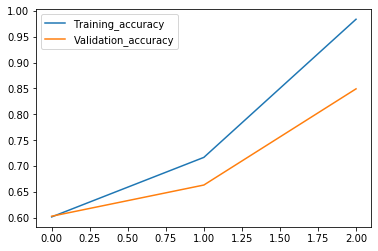

In [20]:
plt.plot(history.history['accuracy'], label= 'Training_accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation_accuracy')
plt.legend();

In [21]:
# Visualize loss for both training and validation set.

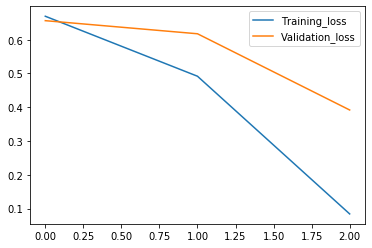

In [22]:
plt.plot(history.history['loss'], label='Training_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.legend();

Based on the chart above, we can deduce that the accuracy rises for both test and training set while the loss falls as well.

In [ ]:
#To summarise, our machine has been trained on predicting whether on a given news headlines that it will create fear in the market. 